## Generative Latent Replay

Experimental code to test generative latent replay on benchmark continual learning problems.

i.e. normalising bottleneck representations and sampling from fitted GMM on latent space.

In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt

# ML imports
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchvision import transforms as T
from avalanche.training import Naive, Replay, plugins
from avalanche.benchmarks.classic import RotatedMNIST, PermutedMNIST

# Local imports
from src import utils, plotting
from src.models import SimpleCNN, SimpleMLP
from src.strategies import LatentReplay, GenerativeLatentReplay


Hyperparameter settings

In [2]:
# Config
device = utils.get_device()

# Dataset specific attributes
dataset = PermutedMNIST
n_classes = 10
n_experiences = 3

# Model specification
model = "mlp"
hidden_size = 100
n_hidden_layers = 2

# Frozen backbone
freeze_depth = 2  # assert freeze_depth <= n_hidden_layers

if model == "mlp":
    latent_layer_number = freeze_depth * 3
elif model == "cnn":
    latent_layer_number = freeze_depth * 2

# Hyperparams
lr = 0.001
l2 = 0.0005
momentum = 0.9

n_epochs = 20
train_mb_size = 128
eval_mb_size = 512

replay_buffer_size = 500
cl_plugins = None  # [plugins.EarlyStoppingPlugin(patience=1, val_stream_name="train_stream")]  # JA: need to set params

eval_every = -1

# Reproducibility
SEED = 109
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


Building base model

In [3]:
# Model
n = 6

if model == "mlp":
    networks = [SimpleMLP(n_classes, hidden_size, n_hidden_layers) for i in range(n)]
    transform = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])

elif model == "cnn":
    networks = [SimpleCNN(n_classes, hidden_size, n_hidden_layers) for i in range(n)]
    transform = T.Compose([T.ToTensor()])


c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Building Continual Learning methods for comparison

In [4]:
# Baseline
naive_strategy = Naive(
    model=networks[0],
    optimizer=SGD(networks[0].parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    train_mb_size=train_mb_size,
    device=device,
    plugins=cl_plugins,
    eval_every=eval_every,
)


In [5]:
# Benchmark - raw and latent replay
replay_strategy = Replay(
    model=networks[1],
    criterion=CrossEntropyLoss(),
    optimizer=SGD(networks[1].parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    train_mb_size=train_mb_size,
    device=device,
    plugins=cl_plugins,
    eval_every=eval_every,
)

# Sanity check - should perform similar to "Replay"
#replay_thawed_strategy = LatentReplay(
#    model=networks[2],
#    train_epochs=n_epochs,
#    eval_mb_size=eval_mb_size,
#    train_mb_size=train_mb_size,
#    subsample_replays=True,
#    rm_sz=replay_buffer_size,
#    latent_layer_num=0,
#    device=device,
#    plugins=cl_plugins,
#    eval_every=eval_every,
#)

lat_replay_strategy = LatentReplay(
    model=networks[3],
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    train_mb_size=train_mb_size,
    subsample_replays=True,
    rm_sz=replay_buffer_size,
    latent_layer_num=latent_layer_number,
    device=device,
    plugins=cl_plugins,
    eval_every=eval_every,
)

gen_replay_strategy = GenerativeLatentReplay(
    model=networks[4],
    rm_sz=replay_buffer_size,
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    latent_layer_num=0,
    device=device,
    eval_every=eval_every,
    plugins=cl_plugins,
)


In [6]:
# Continual learning strategy
gen_lat_replay_strategy = GenerativeLatentReplay(
    model=networks[5],
    rm_sz=replay_buffer_size,
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    latent_layer_num=latent_layer_number,
    device=device,
    eval_every=eval_every,
    plugins=cl_plugins,
)

#print(gen_lat_replay_strategy.model)

In [7]:
strategies = {
    "Naive": {"model": naive_strategy, "results": []},
    #"Replay": {"model": replay_strategy, "results": []},
    #"Replay (re-imp)": {"model": replay_thawed_strategy, "results": []},
    #"Latent Replay": {"model": lat_replay_strategy, "results": []},
    #"Generative Replay": {"model": gen_replay_strategy, "results": []},
    "Generative Latent Replay": {"model": gen_lat_replay_strategy, "results": []},
}

Training loop

In [8]:
for strategy in strategies.keys():
    experiences = dataset(
        n_experiences=n_experiences,
        train_transform=transform,
        eval_transform=transform,
        seed=SEED,
        rotations_list=[0, 60, 300],
    )
    train_stream = experiences.train_stream
    test_stream = experiences.test_stream

    for train_exp in train_stream:
        strategies[strategy]["model"].train(train_exp)
        strategies[strategy]["results"].append(
            strategies[strategy]["model"].eval(train_stream)
        )


-- >> Start of training phase << --
100%|██████████| 469/469 [00:14<00:00, 33.12it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.3036
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1013
100%|██████████| 469/469 [00:12<00:00, 36.40it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.2996
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1198
100%|██████████| 469/469 [00:12<00:00, 36.51it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.2954
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1389
100%|██████████| 469/469 [00:13<00:00, 35.49it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.2862
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1650
100%|██████████| 469/469 [00:13<00:00, 35.02it/s]
Epoch 4 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.2467
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2039
100%|██████████| 469/469 [00:13<00:00, 35.11it/s]
Epoch 5 ended.
	Loss_Epoch/tr

c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\sklearn\mixture\_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Generator trained.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from train stream --
100%|██████████| 118/118 [00:10<00:00, 11.42it/s]
> Eval on experience 0 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp000 = 2.1074
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp000 = 0.3197
-- Starting eval on experience 1 (Task 0) from train stream --
100%|██████████| 118/118 [00:12<00:00,  9.79it/s]
> Eval on experience 1 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp001 = 1.3541
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp001 = 0.5427
-- Starting eval on experience 2 (Task 0) from train stream --
100%|██████████| 118/118 [00:11<00:00, 10.12it/s]
> Eval on experience 2 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp002 = 3.2315
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp002 = 0.1472
-- >> End of eval phase << --
	Loss_Stream/ev

Plotting

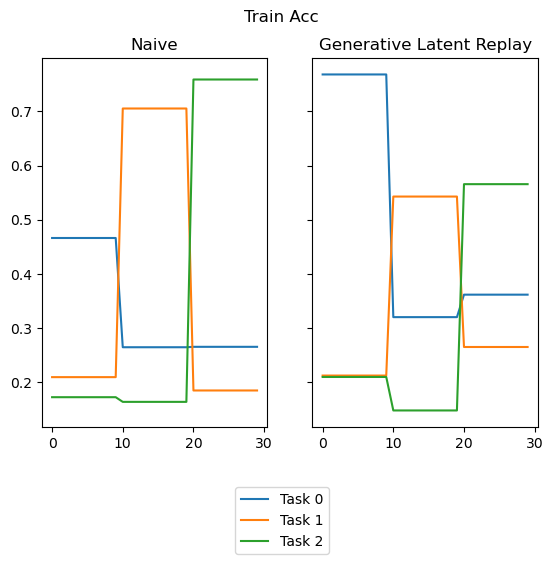

In [10]:
fig, axes = plt.subplots(1, len(strategies), sharey="row")

plotting.plot_multiple_results(
    [s["results"] for s in strategies.values()],
    strategies.keys(),
    axes,
    fig,
    n_experiences,
)


In [27]:
import importlib
importlib.reload(utils)

utils.results_to_df(strategies.keys(), [s["results"] for s in strategies.values()])

,Strategy,Final_Avg_Acc
0,Naive,0.402678
1,Generative Latent Replay,0.397128
